## Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Data format

The dataset is stored in following format:
- input_data_dir
 
 - class_1_dir
   - image_1.png
   - image_2.png
 - class_2_dir
 - class_3_dir

## Split data into train-valid-test set

In [6]:
# Define the training and validation base directories
current_dir = os.getcwd()
train_dir = 'face_detection'
people_list = os.listdir(os.path.join(current_dir,train_dir))


# How many dataset for each people
work_dir = os.path.join(current_dir,train_dir)
for people in people_list:
    working_dir = os.path.join(work_dir,people)
    if os.path.isdir(working_dir):
        print(f'{people} has got {len(os.listdir(working_dir))} dataset')

Virat Kohli has got 48 dataset
Roger Federer has got 74 dataset
Akshay Kumar has got 49 dataset
Robert Downey Jr has got 111 dataset
Brad Pitt has got 119 dataset
Ellen Degeneres has got 41 dataset
Lisa Kudrow has got 70 dataset
Courtney Cox has got 80 dataset
Amitabh Bachchan has got 71 dataset
Tom Cruise has got 51 dataset
Hrithik Roshan has got 43 dataset
Marmik has got 32 dataset
Billie Eilish has got 96 dataset
Andy Samberg has got 86 dataset
Hugh Jackman has got 79 dataset
Dwayne Johnson has got 60 dataset
Margot Robbie has got 67 dataset
Zac Efron has got 84 dataset
Alia Bhatt has got 78 dataset
Kashyap has got 28 dataset
Charlize Theron has got 76 dataset
Alexandra Daddario has got 91 dataset
Priyanka Chopra has got 100 dataset
Henry Cavill has got 73 dataset
.ipynb_checkpoints has got 0 dataset
Camila Cabello has got 87 dataset
Vijay Deverakonda has got 115 dataset
Jessica Alba has got 107 dataset
Natalie Portman has got 35 dataset


In [52]:
import splitfolders
splitfolders.ratio(work_dir, output="face_detection_output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 2051 files [00:00, 2868.58 files/s]


## Print sample images

Henry Cavill sample image:


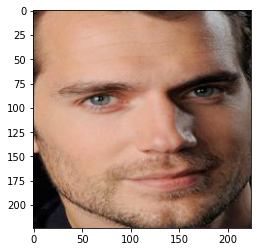

In [7]:
# print sample images
# to print
people = 'Henry Cavill'
index = 10

def print_sample_images(people,index):
    sample_dir = os.path.join(work_dir,people)
    print(f"{people} sample image:")
    sample_img = os.path.join(sample_dir,os.listdir(sample_dir)[index])

    plt.imshow(load_img(f"{sample_img}"))
    plt.show()
print_sample_images(people,index)

## Load data using ImageDataGenerator

In [9]:
def train_val_generators(TRAINING_DIR,VALIDATION_DIR,TEST_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator: tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  train_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      color_mode = 'rgb',
                                                      target_size=(224, 224),
                                                     seed = 2000)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  valid_datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip=True)
  validation_generator = valid_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      color_mode='rgb',
                                                      target_size=(224, 224),
                                                    seed = 2000)
    
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_generator = valid_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=1, 
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      shuffle = False)

  ### END CODE HERE
  return train_generator, validation_generator, test_generator

In [10]:
train_dir = 'face_detection_output/train'
test_dir = 'face_detection_output/test'
valid_dir = 'face_detection_output/val'

In [11]:
train_generator, validation_generator,test_generator = train_val_generators(train_dir,valid_dir,test_dir)

Found 1629 images belonging to 29 classes.
Found 193 images belonging to 29 classes.
Found 229 images belonging to 29 classes.


## Transfer Learning

In [442]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import RMSprop
def create_transfer_model():
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False)
    # Freeze base model
    base_model.trainable = False

    # Create new model on top.
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024,activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    outputs = tf.keras.layers.Dense(29,activation = 'softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(RMSprop(lr = 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    return model


In [443]:
efficient_net_model = create_transfer_model()

In [444]:
efficient_net_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_24  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_121 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_46 (Dropout)        (None, 1024)              0         
                                                                 
 dense_122 (Dense)           (None, 29)                29725     
                                                          

## Self-created CNN model

In [387]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        print('current learning rate',lr * tf.math.exp(-0.1))
        return lr * tf.math.exp(-0.1)

def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16,(3,3),strides=(1, 1),padding='valid',activation='relu',input_shape = (224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
      tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),padding='valid',activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
      tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1),padding='valid',activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=None,padding='valid'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(128,activation = 'relu'),
      tf.keras.layers.Dense(64,activation = 'relu'),
      tf.keras.layers.Dense(29,activation = 'softmax')
  ])

  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
  return model

In [305]:
model = create_model()

In [306]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 26, 26, 64)     

## Training the model

In [449]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.005,patience=3)
history = efficient_net_model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [callback,callback2])

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 1.7504 - accuracy: 0.4604

2022-09-22 02:24:19.069053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 31s 598ms/step - loss: 1.7504 - accuracy: 0.4604 - val_loss: 1.7443 - val_accuracy: 0.4819 - lr: 0.0010
Epoch 2/50
25/51 [=============>................] - ETA: 12s - loss: 2.0681 - accuracy: 0.3689

KeyboardInterrupt: 

## Plot History & Save Model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


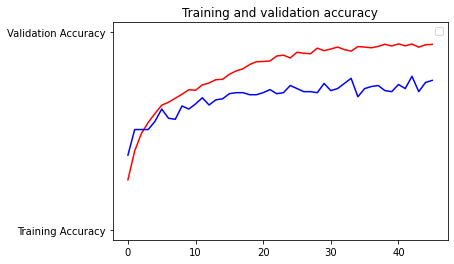

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


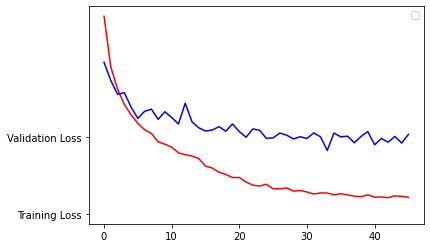

In [416]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend()
plt.show()

## Save and load model

In [417]:
efficient_net_model.save('efficient_net_model.h5')

In [2]:
model = tf.keras.models.load_model('efficient_net_model.h5')

2022-09-28 23:22:09.203416: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-28 23:22:09.204423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


## Evaluating Prediction

In [12]:
model.evaluate(test_generator)

2022-09-28 23:23:01.492491: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-28 23:23:01.779049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 5s 20ms/step - loss: 0.9333 - accuracy: 0.7380


[0.933340311050415, 0.7379912734031677]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(test_generator)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories=test_generator.labels

  1/229 [..............................] - ETA: 1:34

2022-09-28 23:23:12.830603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 5s 18ms/step


In [14]:
predicted_categories

<tf.Tensor: shape=(229,), dtype=int64, numpy=
array([15,  5, 25, 17, 25, 15,  2,  2,  2,  2,  2,  2,  2,  3,  2,  2,  3,
        3,  3,  8,  3,  3,  3,  3,  3,  4,  4,  4,  4,  7,  4,  4,  4,  5,
        5,  5, 17,  5,  5,  5,  5, 23,  5,  6,  6,  6,  6, 18,  6,  6,  6,
        6,  6, 19,  7, 18,  7,  7,  7,  7, 13,  7,  7,  7,  7,  7,  7, 22,
        8,  8,  8,  8,  8,  8,  8,  3,  8,  9,  9, 19, 19,  9, 19,  3,  9,
        9, 10, 10, 10, 10,  8, 10, 10, 10,  1, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13,  9, 26, 25, 15, 13,  7, 13, 14, 15, 14,  1, 14, 15,
       14, 11, 15, 15, 26, 15, 23,  5, 16, 16, 16, 16, 16, 18, 16,  9, 21,
       16, 16,  3, 17, 13, 17, 17, 18, 18, 18,  9, 18, 18, 18, 19,  6,  9,
       21,  6, 19, 19, 19, 20, 20, 20, 20, 22, 21, 21, 16, 22, 22, 22, 22,
       18, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 11,  5, 23,  4, 23,
       23, 24, 24, 24, 24, 24, 14, 24, 24, 13,  1, 25,  7, 25, 25, 26, 26,
       26, 15, 26, 26, 26, 26, 26, 26, 26,  1, 14, 27,

In [15]:
true_categories

array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,
       19, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 28

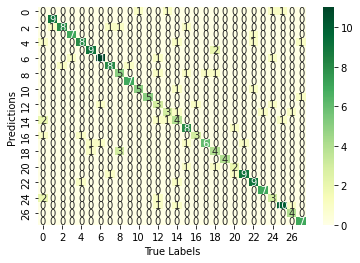

In [16]:
cm = confusion_matrix(predicted_categories, true_categories)

heatmap = sns.heatmap(cm, annot=True, cmap='YlGn')
plt.xlabel("True Labels")
plt.ylabel("Predictions")
plt.show()

## Find similar faces

In [17]:
class_dict=test_generator.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key

In [18]:
def similar_person(confusion_matrix,class_dict):
    np.fill_diagonal(confusion_matrix,0)
    row,column = np.where(confusion_matrix == np.amax(confusion_matrix))
    print(f'{class_dict[row[0]]} is similar to {class_dict[column[0]]}')
    return class_dict[row[0]],class_dict[column[0]]
    
def print_similar_person(person1,person2,index1,index2):
    print_sample_images(person1,index1)
    print_sample_images(person2,index2)

Lisa Kudrow is similar to Camila Cabello
Lisa Kudrow sample image:


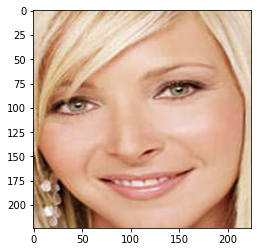

Camila Cabello sample image:


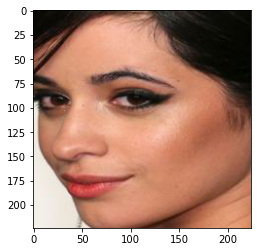

In [19]:
p1,p2 = similar_person(cm,rev_dict)
print_similar_person(p1,p2,5,7)